<a href="https://colab.research.google.com/github/gomyk/NNStudy/blob/moonwon/%5BRL%5D%5BDQN%5D%5BMW%5D%20CartPole-v0%20(No%20CNN)%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get install x11-utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [0]:
import gym
from gym.wrappers import Monitor
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import base64

from IPython.display import HTML

from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

from google.colab import output

display = Display(visible=0, size=(400,600),)
display.start()
env = gym.make("CartPole-v1")
env._max_episode_steps = 5000
#env = gym.wrappers.Monitor(gym.make("CartPole-v1"), "video", force=True, video_callable=lambda c:c%100 ==0)

# GPU를 사용할 경우
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """transition 저장"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [0]:

class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Linear 입력의 연결 숫자는 conv2d 계층의 출력과 입력 이미지의 크기에
        # 따라 결정되기 때문에 따로 계산을 해야합니다.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        
        self.head = nn.Linear(linear_input_size, outputs)
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [0]:
HIDDEN_SIZE = 256
class DQN_custom(nn.Module):

    def __init__(self, obs_size, outputs):
        super(DQN_custom, self).__init__()
        self.linear = nn.Linear(obs_size, HIDDEN_SIZE)
        self.head = nn.Linear(HIDDEN_SIZE, outputs)
    def forward(self, x):
        x = F.relu(self.linear(x))
        return self.head(x)

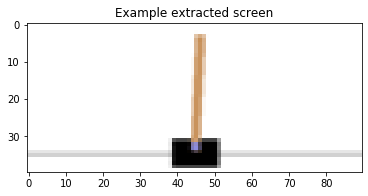

In [6]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # gym이 요청한 화면은 400x600x3 이지만, 가끔 800x1200x3 처럼 큰 경우가 있습니다.
    # 이것을 Torch order (CHW)로 변환한다.
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # 카트는 아래쪽에 있으므로 화면의 상단과 하단을 제거하십시오.
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # 카트를 중심으로 정사각형 이미지가 되도록 가장자리를 제거하십시오.
    screen = screen[:, :, slice_range]
    # float 으로 변환하고,  rescale 하고, torch tensor 로 변환하십시오.
    # (이것은 복사를 필요로하지 않습니다)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # 크기를 수정하고 배치 차원(BCHW)을 추가하십시오.
    return resize(screen).unsqueeze(0).to(device)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [0]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.01
EPS_DECAY = 2000
TARGET_UPDATE = 10
LR = 0.01
MEMORY_SIZE = 10000
EPISODE_SIZE = 1500

# gym 행동 공간에서 행동의 숫자를 얻습니다.
n_actions = env.action_space.n
n_obvs = 4

policy_net = DQN_custom(n_obvs, n_actions).to(device)
policy_net.eval()
target_net = DQN_custom(n_obvs, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
memory = ReplayMemory(MEMORY_SIZE)


steps_done = 0

def select_action(obs):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            obs = torch.FloatTensor(obs).to(device)
            output = policy_net(obs).cpu()
            predicted = np.argmax(output.data.numpy())
            return torch.tensor([[predicted]],device=device, dtype=torch.long)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # 100개의 에피소드 평균을 가져 와서 도표 그리기
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

In [0]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return -1
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). 이것은 batch-array의 Transitions을 Transition의 batch-arrays로
    # 전환합니다.
    batch = Transition(*zip(*transitions))

    state_batch = torch.cat(batch.state).to(device)
    reward_batch = torch.cat(batch.reward).to(device)
    action_batch = torch.cat(batch.action).to(device)
 
    non_final_mask = map(lambda s: s is not None, batch.next_state)
    non_final_mask = tuple(non_final_mask)
    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.BoolTensor(non_final_mask)

    # We don't want to backprop through the expected action values and volatile
    # will save us on temporarily changing the model parameters'
    # requires_grad to False!
    non_final_next_states = [s.view(1, -1) for s in batch.next_state if s is not None]
    non_final_next_states = torch.cat(non_final_next_states, 0).to(device)
  

    # Q(s_t, a) 계산 - 모델이 Q(s_t)를 계산하고, 취한 행동의 열을 선택합니다.
    # 이들은 policy_net에 따라 각 배치 상태에 대해 선택된 행동입니다.
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # 모든 다음 상태를 위한 V(s_{t+1}) 계산
    # non_final_next_states의 행동들에 대한 기대값은 "이전" target_net을 기반으로 계산됩니다.
    # max(1)[0]으로 최고의 보상을 선택하십시오.
    # 이것은 마스크를 기반으로 병합되어 기대 상태 값을 갖거나 상태가 최종인 경우 0을 갖습니다.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # 기대 Q 값 계산
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    # Huber 손실 계산
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    # 모델 최적화
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    return loss.cpu().data.numpy()

In [0]:
num_episodes = EPISODE_SIZE
for i_episode in range(num_episodes):
    # 환경과 상태 초기화
    obv = env.reset()
    total_loss = 0
    for t in count():
        # 행동 선택과 수행
        action = select_action(obv)
        next_obv, reward, done, _ = env.step(action.item())
        if done:
            reward -= 100
        reward = torch.tensor([reward], device=device)

        if not done:
          next_state = torch.FloatTensor([next_obv])
        else:
          next_state = None
        # 메모리에 변이 저장
        assert obv is not None
        memory.push(torch.FloatTensor([obv]), action, next_state, reward)

        # 다음 상태로 이동
        obv = next_obv

        # 최적화 한단계 수행(목표 네트워크에서)
        total_loss += optimize_model()
        if done:
            E = eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * steps_done / EPS_DECAY)
            episode_durations.append(t + 1)
            print('%d episode , %d step , %.2f Loss, %.2f Threshold'%(i_episode,t+1,total_loss/(t+1),E))
            plot_durations()
            total_loss = 0
            break
    #목표 네트워크 업데이트, 모든 웨이트와 바이어스 복사
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.show()

0 episode , 13 step , -1.00 Loss, 0.89 Threshold
1 episode , 57 step , -1.00 Loss, 0.87 Threshold
2 episode , 48 step , -1.00 Loss, 0.85 Threshold
3 episode , 24 step , 1.18 Loss, 0.84 Threshold
4 episode , 12 step , 2.92 Loss, 0.83 Threshold
5 episode , 26 step , 2.98 Loss, 0.82 Threshold
6 episode , 25 step , 3.18 Loss, 0.81 Threshold
7 episode , 17 step , 3.58 Loss, 0.81 Threshold
8 episode , 22 step , 2.93 Loss, 0.80 Threshold
9 episode , 29 step , 3.40 Loss, 0.79 Threshold
10 episode , 19 step , 3.36 Loss, 0.78 Threshold
11 episode , 19 step , 3.52 Loss, 0.77 Threshold
12 episode , 17 step , 3.58 Loss, 0.77 Threshold
13 episode , 20 step , 3.91 Loss, 0.76 Threshold
14 episode , 16 step , 4.15 Loss, 0.75 Threshold
15 episode , 32 step , 3.94 Loss, 0.74 Threshold
16 episode , 13 step , 3.40 Loss, 0.74 Threshold
17 episode , 38 step , 4.40 Loss, 0.72 Threshold
18 episode , 12 step , 3.30 Loss, 0.72 Threshold
19 episode , 24 step , 4.22 Loss, 0.71 Threshold
20 episode , 17 step , 4.03